<a href="https://www.kaggle.com/code/kasperlindmark/music-streaming?scriptVersionId=126461293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

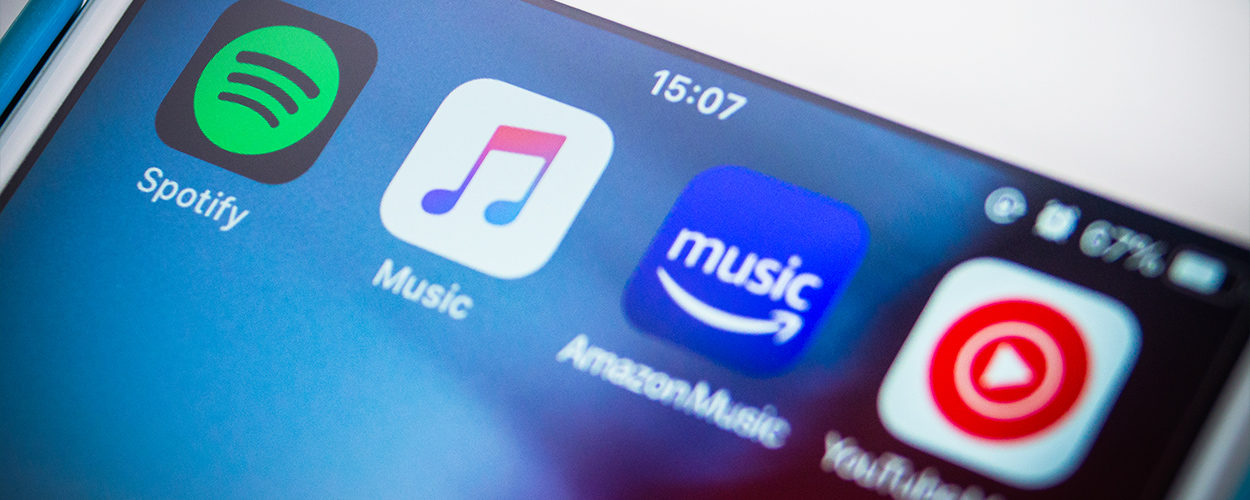

# Introduction
The goal of this project is to explore different metrics of performance for my songs and make a prediction on how my stats will look for the next 360 days. The insights from this analysis will be used in planing new release schedules, audiences for ads, etc

The datasets I will explore, come from Distrokid and Spotify.

## Questions that we will try to answer:

### Streams
* What songs are most popular?
* How many streams do different streaming services generate?
* When do people listen to my songs the most?

### Earnings
* What kind of earnings do streams generate?
* Do all songs generate earnings equally based on popularity? if so why or why not?
* How much have each streaming service paid?
* What do different services pay per stream?

### Predictions
* What could my stats look like in a year/360 days?

## What this analysis won't won't include
* How these stats compare to other artists
* What impact listener traits (Gender, Age, etc) has 

# Start of notebook

In [1]:
# Starting project by importing important tools and defining some important variables
PROJECT_ID = 'Spotify-381011'
import numpy as np
import pandas as pd
from  datetime import datetime as dt

import os
from google.cloud import storage
from io import StringIO
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Set plot color scheme
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
# GCS
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.get_bucket('kl_streaming_data')

In [4]:
# Initializing Distrokid dataframe from GCS
Distrokid_blob = bucket.blob('DistrokidStreamsExport.csv')
Distrokid_s = str(Distrokid_blob.download_as_string(),'utf-8')
Distrokid_df = pd.read_csv(StringIO(Distrokid_s))
Distrokid_df.columns

Index([' Reporting Date', 'Sale Month', 'Store', 'Artist', 'Title', 'ISRC',
       'UPC', 'Quantity', 'Team Percentage', 'Song/Album', 'Country of Sale',
       'Songwriter Royalties Withheld', 'Earnings (USD)'],
      dtype='object')

# Preparing data

In [5]:
Distrokid_df

,Reporting Date,Sale Month,Store,Artist,Title,ISRC,UPC,Quantity,Team Percentage,Song/Album,Country of Sale,Songwriter Royalties Withheld,Earnings (USD)
0,2018-08-19,2018-06,Spotify,Kasper Lindmark,When We're Apart,QZDA51856700,NaN,1,100,Song,SE,0,0.003733
1,2018-08-19,2018-06,Spotify,Kasper Lindmark,When We're Apart,QZDA51856700,NaN,1,100,Song,SE,0,0.004235
2,2018-08-19,2018-06,Spotify,Kasper Lindmark,When We're Apart,QZDA51856700,NaN,2,100,Song,SE,0,0.002564
3,2018-08-19,2018-06,Spotify,Kasper Lindmark,You're Glowing,QZDA51856703,NaN,2,100,Song,SE,0,0.007466
4,2018-08-19,2018-06,Spotify,Kasper Lindmark,You're Glowing,QZDA51856703,NaN,2,100,Song,SE,0,0.002564
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597137,2023-03-13,2023-01,Tidal,Kasper Lindmark,Happy,QZDA51880636,8.400917e+11,1,100,Song,DE,0,0.007406
597138,2023-03-13,2023-01,Tidal,Kasper Lindmark,Superkiss,QZDA81800582,8.400908e+11,2,100,Song,CL,0,0.004380
597139,2023-03-13,2023-01,Tidal,Kasper Lindmark,Decide,QZDA81800579,8.400908e+11,2,100,Song,CL,0,0.004380
597140,2023-03-13,2023-01,Tidal,Kasper Lindmark,Blushing,QZDA81800584,8.400908e+11,2,100,Song,CL,0,0.004380


In [6]:
# Extracting the data we're interrested in
subset_df = Distrokid_df[['Sale Month', 'Store', 'Title',
                       'Quantity', 'Song/Album', 'Country of Sale',
                       'Earnings (USD)']]

# What unique stores have we gotten data from
print(f'Unique stores : {subset_df.Store.nunique()},\n Stores : {subset_df.Store.unique()}')

Unique stores : 31,
 Stores : ['Spotify' 'Apple Music' 'YouTube (Ads)' 'YouTube (Red)' 'Tidal'
 'Amazon Unlimited (Streaming)' 'Google Play All Access'
 'Amazon Prime (Streaming)' 'Deezer' 'Napster' 'iTunes' 'kkbox' 'Anghami'
 'Google Play' 'iTunes Match' 'Amazon (Downloads)'
 'DistroKid Referral Program' 'Saavn' 'TikTok' 'YouTube (Audio)' 'NetEase'
 'Medianet' 'iHeart Radio' 'Facebook' 'Medianet (Downloads)' 'Yandex'
 'Pandora' 'Resso' 'Boomplay' 'Snap' 'Qobuz Streaming']


## The attributes we are interrested in
There is data from 31 stores. However, we're only interrested in data from streaming services, Spotify, Apple Music, etc. So we'll remove the stores with one time transactions, such as Distrokid Referral Program, etc.

We will also remove some songs that are only resulting in 25% revenue, these songs I wrote with other artists and include Pleasant & Intentions

In [7]:
# Pruning unwanted store records
subset_df = subset_df[(subset_df['Store'].str.lower() != 'distrokid referral program') & 
                (subset_df['Store'].str.lower() != 'amazon (downloads)') & 
                (subset_df['Store'].str.lower() != 'google play') &
                (subset_df['Store'].str.lower() != 'itunes') & 
                (subset_df['Store'].str.lower() != 'itunes match') & 
                (subset_df['Store'].str.lower() != 'iheart radio') & 
                (subset_df['Store'].str.lower() != 'medianet (downloads)')]

# Pruning unwanted store records
subset_df = subset_df[(subset_df['Title'].str.lower() != 'pleasant') & 
                (subset_df['Title'].str.lower() != 'intentions')]

print(f'Unique stores : {subset_df.Store.nunique()}')

Unique stores : 24


In [8]:
subset_df.index = pd.to_datetime(subset_df['Sale Month'], format='%Y-%m')
subset_df = subset_df.drop('Sale Month', axis = 1)
subset_df

,Store,Title,Quantity,Song/Album,Country of Sale,Earnings (USD)
Sale Month,,,,,,
2018-06-01,Spotify,When We're Apart,1,Song,SE,0.003733
2018-06-01,Spotify,When We're Apart,1,Song,SE,0.004235
2018-06-01,Spotify,When We're Apart,2,Song,SE,0.002564
2018-06-01,Spotify,You're Glowing,2,Song,SE,0.007466
2018-06-01,Spotify,You're Glowing,2,Song,SE,0.002564
...,...,...,...,...,...,...
2023-01-01,Tidal,Happy,1,Song,DE,0.007406
2023-01-01,Tidal,Superkiss,2,Song,CL,0.004380
2023-01-01,Tidal,Decide,2,Song,CL,0.004380


# Monthly earnings per store
To prepare this table we can use the function pivot_table. We have all the data we need in the 'subset' data frame, so we can use that as a starting point. We then need to define the structure of the new table, it should be listed by date, where the columns are stores, and the values are the store earnings per month

In [9]:
store_earnings_df = subset_df.pivot_table(index=subset_df.index, columns=['Store'], values=['Earnings (USD)'],aggfunc='sum').copy()
store_earnings_df.head()

Earnings (USD)                                         \
Store      Amazon Prime (Streaming) Amazon Unlimited (Streaming)   Anghami   
Sale Month                                                                   
2018-06-01                      NaN                          NaN       NaN   
2018-07-01                 0.001761                     0.038926       NaN   
2018-08-01                      NaN                     0.015588       NaN   
2018-09-01                      NaN                          NaN       NaN   
2018-10-01                      NaN                          NaN  0.051539   

                                                                           \
Store      Apple Music Boomplay    Deezer Facebook Google Play All Access   
Sale Month                                                                  
2018-06-01         NaN      NaN       NaN      NaN                    NaN   
2018-07-01    3.762374      NaN  0.015852      NaN               0.381668   
2018-08-01    8.652788      NaN  0.060064      NaN               0.308042   
2018-09-01   12.478487      NaN  0.240794      NaN               0.545963   
2018-10-01   14.708349      NaN  3.681046      NaN               0.590728   

                               ...                                             \
Store      Medianet   Napster  ...     Saavn Snap    Spotify     Tidal TikTok   
Sale Month                     ...                                              
2018-06-01      NaN       NaN  ...       NaN  NaN   0.159449       NaN    NaN   
2018-07-01      NaN       NaN  ...       NaN  NaN  10.795658  0.213983    NaN   
2018-08-01      NaN  1.087879  ...       NaN  NaN  15.669226  0.519158    NaN   
2018-09-01      NaN  0.793612  ...       NaN  NaN  72.485754  0.176947    NaN   
2018-10-01      NaN       NaN  ...  0.043967  NaN  68.294340  0.055903    NaN   

                                                                         
Store      Yandex YouTube (Ads) YouTube (Audio) YouTube (Red)     kkbox  
Sale Month                                                               
2018-06-01    NaN           NaN             NaN           NaN       NaN  
2018-07-01    NaN      0.178000             NaN      0.991000       NaN  
2018-08-01    NaN      0.547703             NaN      0.849132       NaN  
2018-09-01    NaN      0.406567             NaN      0.078201  0.040985  
2018-10-01    NaN      0.335827             NaN      0.975072       NaN  

[5 rows x 24 columns]

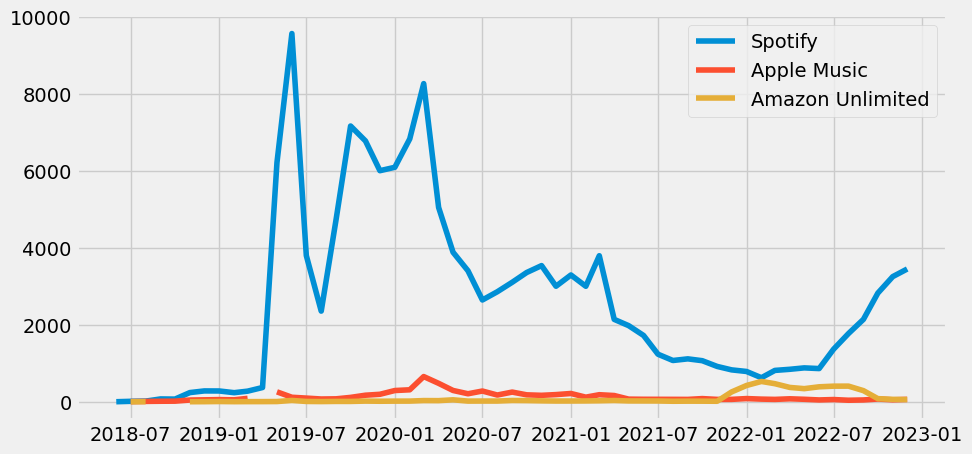

In [10]:
fig = plt.figure(figsize=(10, 5)) # size in inch
plt.plot(store_earnings_df['Earnings (USD)']['Spotify'])
plt.plot(store_earnings_df['Earnings (USD)']['Apple Music'])
plt.plot(store_earnings_df['Earnings (USD)']['Amazon Unlimited (Streaming)'])
plt.legend(['Spotify', 'Apple Music', 'Amazon Unlimited'], loc='upper right')
plt.show()

We can see that Spotify's the top earning service for my catalogue. It's the highest earning service by a long shot, with Apply Music and Amazon Unlimited (Streaming) coming second and third.

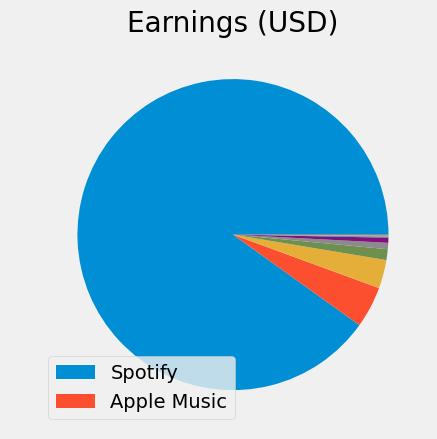

In [11]:
store_earnings_sum = store_earnings_df.sum().sort_values(ascending=False)
store_earnings_sum.plot(kind='pie', title='Earnings (USD)', label=' ',labeldistance=None).legend(['Spotify', 'Apple Music'], loc='lower left')

<AxesSubplot:title={'center':'Top 5 earning services (USD)'}, ylabel='Store'>

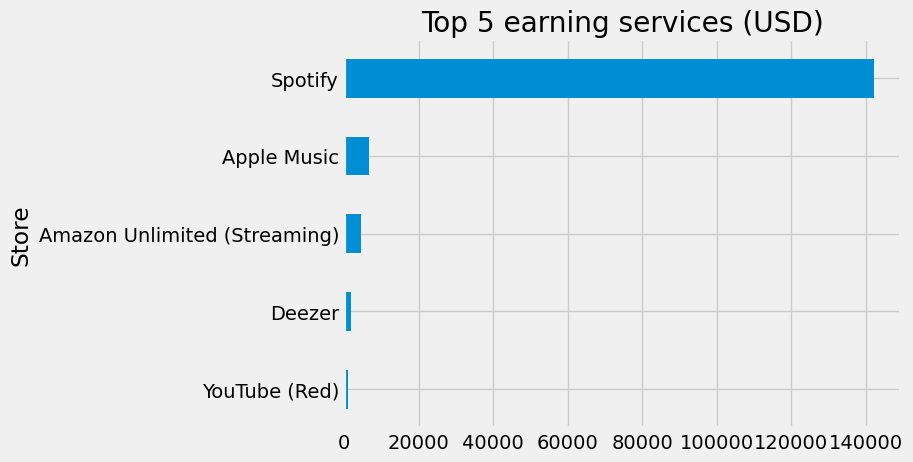

In [12]:
# Plotting streaming service earnings
store_earnings_sub = subset_df.groupby('Store')['Earnings (USD)'].sum()
store_earnings_sub\
.nlargest(5)\
.sort_values()\
.plot(
    kind = 'barh',
    title = 'Top 5 earning services (USD)')

## What does monthly revenue look like?

<AxesSubplot:title={'center':'Monthly earnings (USD)'}, xlabel='Sale Month'>

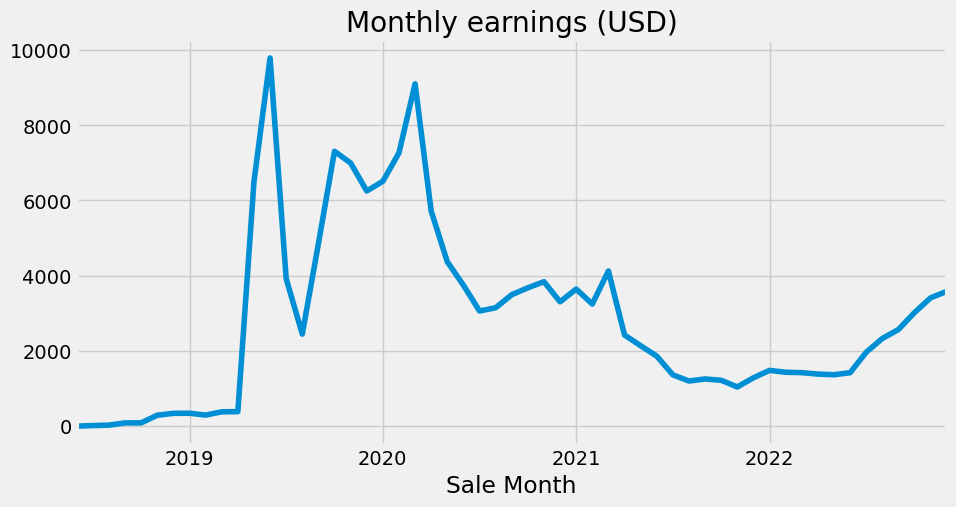

In [13]:
# Plotting streaming service earnings
fig = plt.figure(figsize=(10, 5)) # size in inch
monthly_earnings_df = subset_df.groupby('Sale Month')['Earnings (USD)'].sum()
monthly_earnings_df = monthly_earnings_df[:-1]
monthly_earnings_df\
.plot(
    kind = 'line',
    title = 'Monthly earnings (USD)')

In [14]:
monthly_earnings_df.tail(10)

Sale Month
2022-03-01    1422.707653
2022-04-01    1385.023884
2022-05-01    1367.999958
2022-06-01    1421.814543
2022-07-01    1964.215862
2022-08-01    2331.830930
2022-09-01    2568.371431
2022-10-01    3021.300707
2022-11-01    3412.213777
2022-12-01    3583.928565
Name: Earnings (USD), dtype: float64

## How many streams per month?

<AxesSubplot:title={'center':'Monthly streams'}, xlabel='Sale Month'>

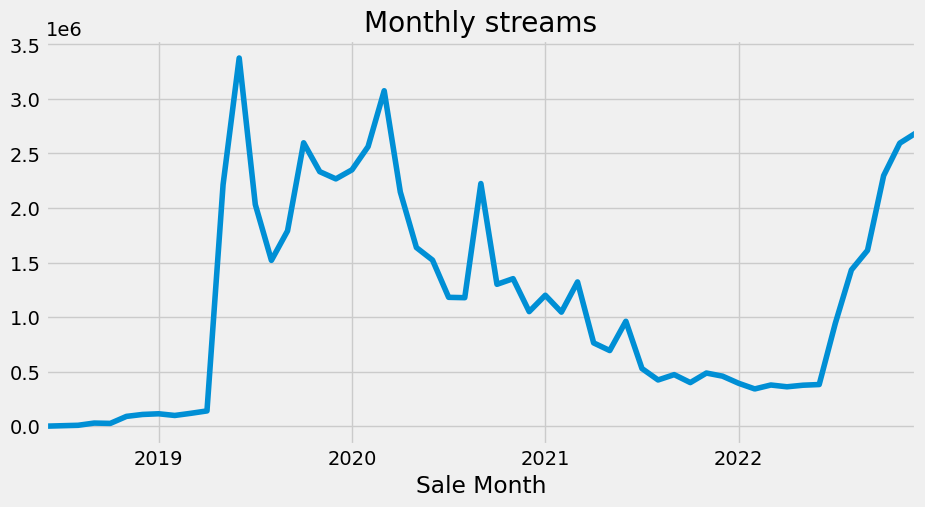

In [15]:
# Plotting streaming service earnings
fig = plt.figure(figsize=(10, 5)) # size in inch
streams_distrokid_df = subset_df.groupby('Sale Month')['Quantity'].sum()
streams_distrokid_df = streams_distrokid_df[:-1]
streams_distrokid_df\
.plot(
    kind = 'line',
    title = 'Monthly streams')

# Earnings & Streams 

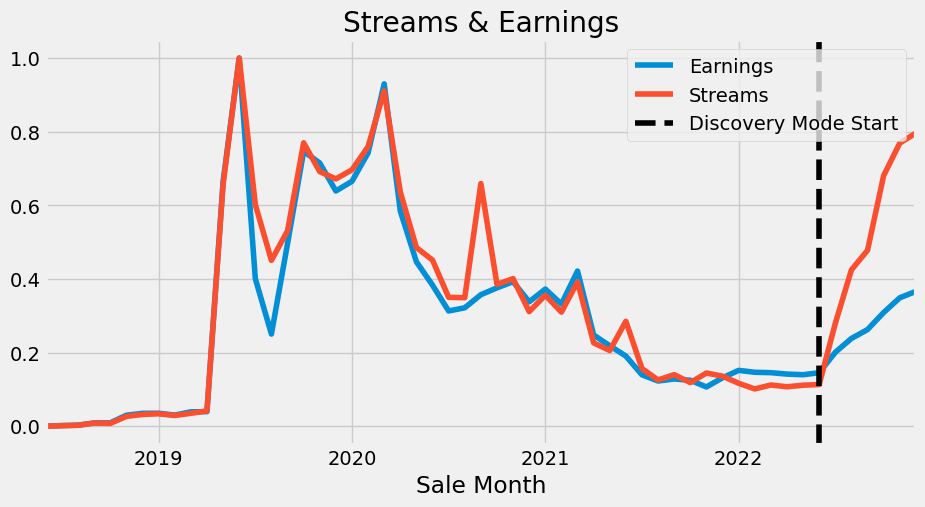

In [16]:
scaler = MinMaxScaler()
fig, ax = plt.subplots(figsize=(10, 5))

combined_df = monthly_earnings_df.to_frame().join(streams_distrokid_df.to_frame())
scaled_df = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns)
scaled_df = scaled_df.set_index(combined_df.index)

scaled_df['Earnings (USD)'].plot(title = 'Streams & Earnings')
scaled_df['Quantity'].plot()

discovery_date = '2022-06-01'
ax.axvline(discovery_date ,color='black', ls='--', label='Discovery Mode start')
ax.legend(['Earnings', 'Streams', 'Discovery Mode Start'])
plt.show()

## Earnings falling behind?

We can see a recent trend of streams rising more than the earnings. The reason behind Earnings not following the same path in the most recent spike in streams, can be explained by Spotify's new Discover Mode program. Which promotes songs on Spotify for a 30% cut of the revenue generated in Discovery Mode contexts.

As we can see when comparing the graphs, the different spikes cause monthly earnings/stream to go down or spike

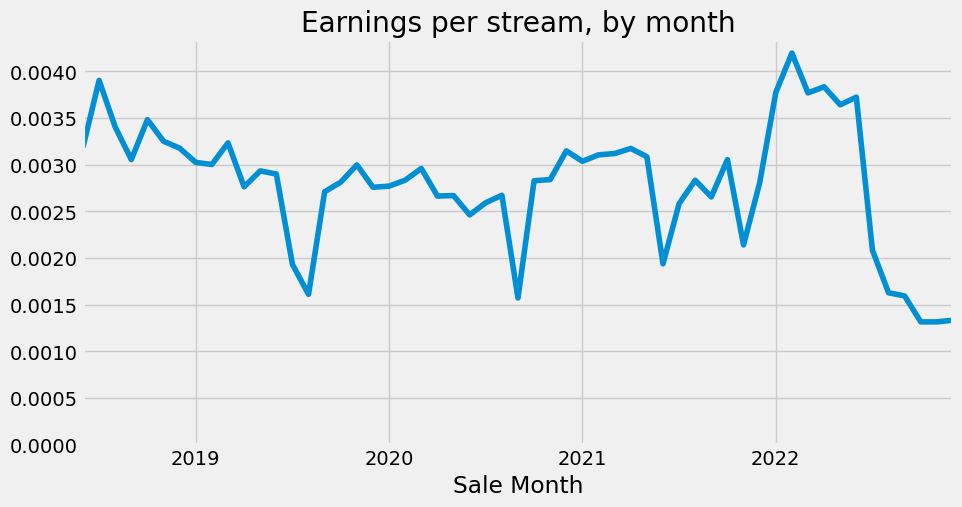

In [17]:
# Plotting streaming service earnings
fig, ax = plt.subplots(figsize=(10, 5))
monthly_eps = monthly_earnings_df/streams_distrokid_df
monthly_eps.name = 'Earnings/Stream'
monthly_eps\
.plot(
    kind = 'line',
    title = 'Earnings per stream, by month')
plt.gca().set_ylim(bottom=0)
plt.show()

The earlier valleys come from releases that I dont get 100% royalties from, so these dilute the USD/Stream value, and later in the chart we can see a big drawn out peak, this peak in earnings/stream can be explained by a short burst of new streams from Amazon Unlimited.

# Data from Spotify for Arists
The benefit of Spotify's data is that they report daily, unlike Distrokid's data which basically are the same stats but reported monthly.

In [18]:
Spotify_blob = bucket.blob('2015-2023_SpotifyStats.csv')
Spotify_s = str(Spotify_blob.download_as_string(),'utf-8')
spotify_df = pd.read_csv(StringIO(Spotify_s))

spotify_df = spotify_df.set_index(pd.to_datetime(spotify_df.date, format='%Y-%m-%d'))
spotify_df = spotify_df.drop('date', axis=1)
spotify_df.head()

,listeners,streams,followers
date,,,
2023-03-26,26387,61361,4634
2023-03-25,24505,56152,4630
2023-03-24,26667,63712,4628
2023-03-23,29490,70194,4626
2023-03-22,29514,68747,4620


<AxesSubplot:title={'center':'Daily streams'}, xlabel='date'>

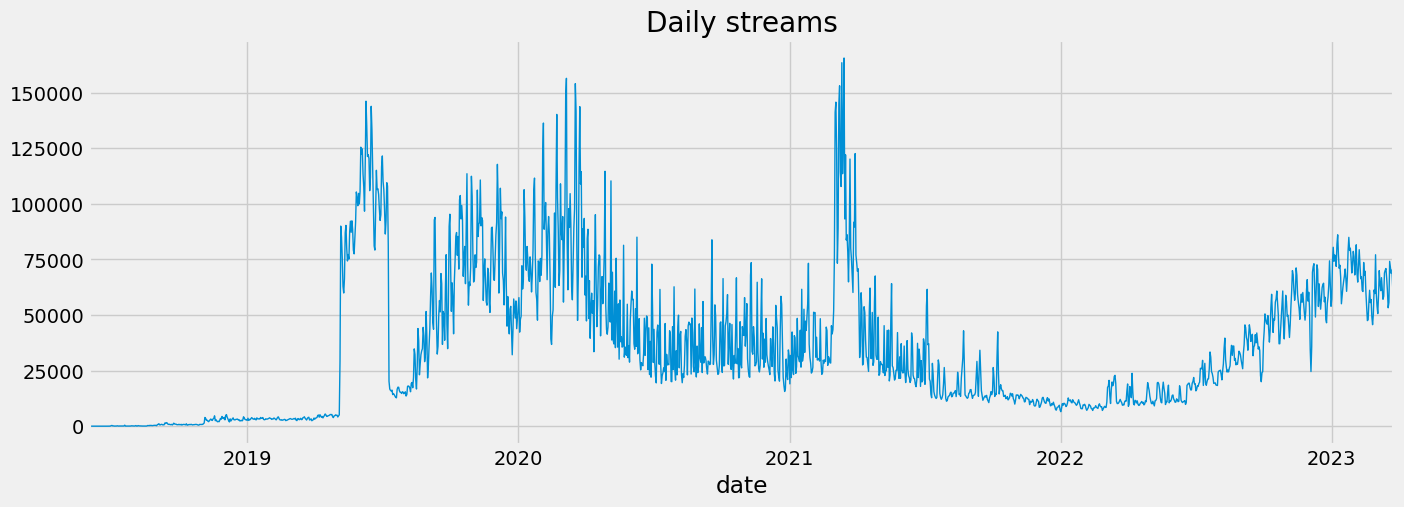

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
spotify_df = spotify_df.loc[spotify_df.index > '2018-06-01']
spotify_df.streams\
.plot(
    kind = 'line',
    lw='1',
    title = 'Daily streams')

## Spotify's earnings/stream

In [20]:
# Get Spotify earnings
spotify_earnings = subset_df.loc[subset_df.Store == "Spotify"]
spotify_earnings = spotify_earnings.groupby('Sale Month')['Earnings (USD)'].sum()

In [21]:
# Get monthly streams from spotify data
spotify_earnings_streams = spotify_df.drop(["listeners", "followers"], axis=1)

spotify_earnings_streams = spotify_earnings_streams.reset_index()
spotify_earnings_streams['date'] = spotify_earnings_streams['date'].apply(lambda dt: dt.replace(day=1))
spotify_earnings_streams.set_index('date', inplace=True)

spotify_earnings_streams = spotify_earnings_streams.groupby('date').sum()

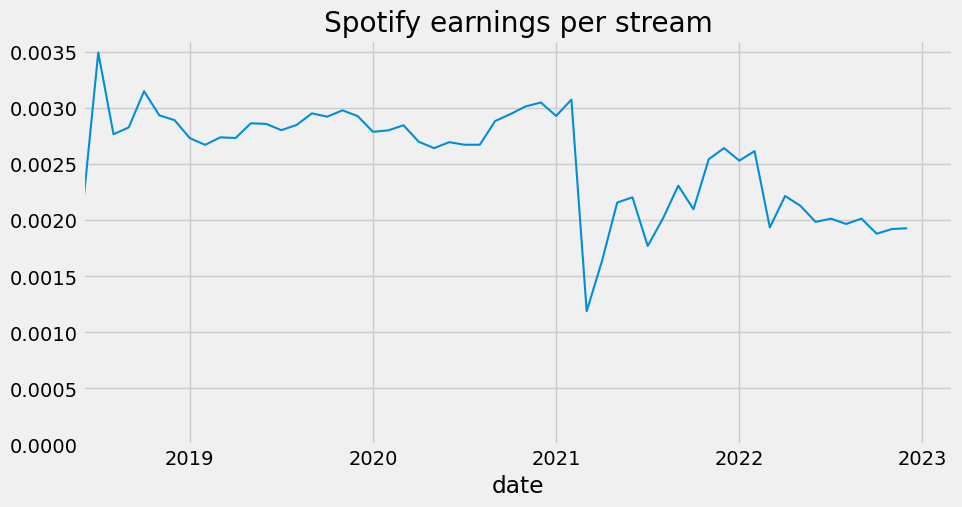

In [22]:
# Merging earnings and streams
spotify_earnings_streams = spotify_earnings_streams.merge(spotify_earnings, how='left', left_index=True, right_index=True)

# Add earnings per stream to df and plot
spotify_earnings_streams["eps"] = spotify_earnings_streams["Earnings (USD)"]/spotify_earnings_streams["streams"]

# Display resulting graph
fig, ax = plt.subplots(figsize=(10, 5))
spotify_earnings_streams.eps\
.plot(
    kind = 'line',
    lw='1.5',
    title = 'Spotify earnings per stream')
plt.ylim(bottom=0)
plt.show()

# Songs performance

<AxesSubplot:title={'center':'Earnings per song (USD)'}, ylabel='Title'>

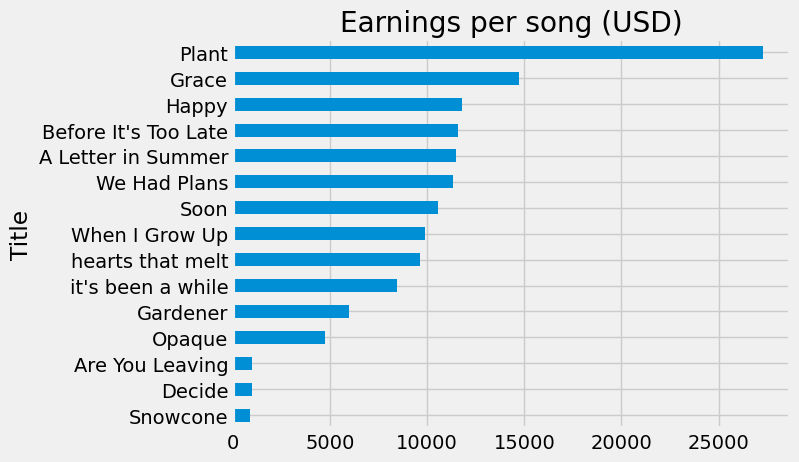

In [23]:
#P lotting top 15 earning songs 
top_earning_songs = subset_df.groupby('Title')['Earnings (USD)'].sum()
top_earning_songs.nlargest(15).sort_values().plot(
    kind = 'barh',
    title = 'Earnings per song (USD)')

<AxesSubplot:title={'center':'Streams per song'}, ylabel='Title'>

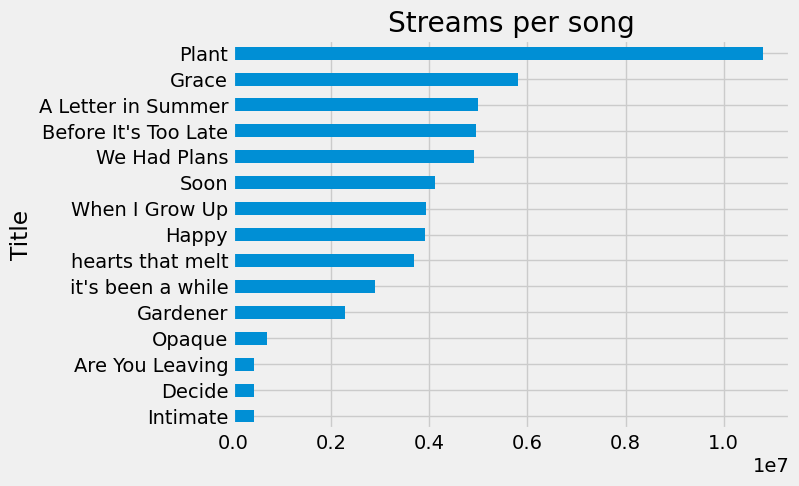

In [24]:
#Plotting top 15 streamed songs
top_streamed_songs = subset_df.groupby('Title')['Quantity'].sum().sort_values()
top_streamed_songs.nlargest(15).sort_values().plot(
    kind = 'barh', 
    title ='Streams per song')

## Song earnings / stream

<AxesSubplot:title={'center':'Song earnings/stream'}, ylabel='Title'>

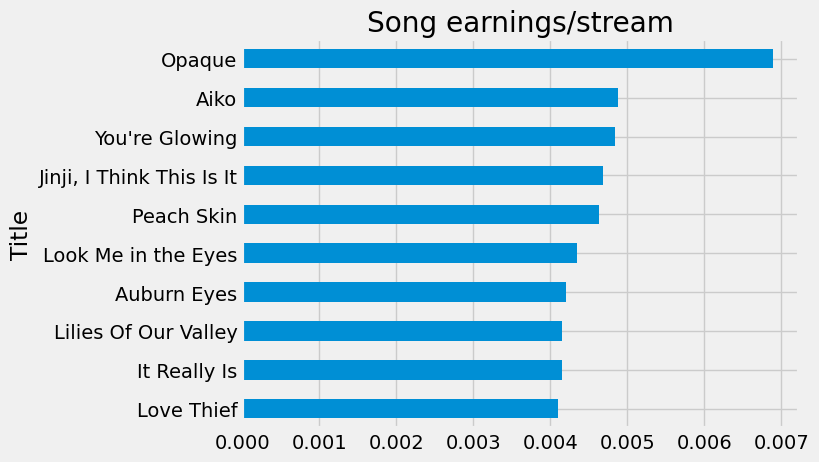

In [25]:
#Plotting song earnings per stream
song_eps = (top_earning_songs/top_streamed_songs).sort_values(ascending=True)
song_eps.nlargest(10).sort_values().plot(
    kind = 'barh', 
    title = 'Song earnings/stream')

# Streams generated by different services

<AxesSubplot:title={'center':'Top 5 popular services (streams)'}, ylabel='Store'>

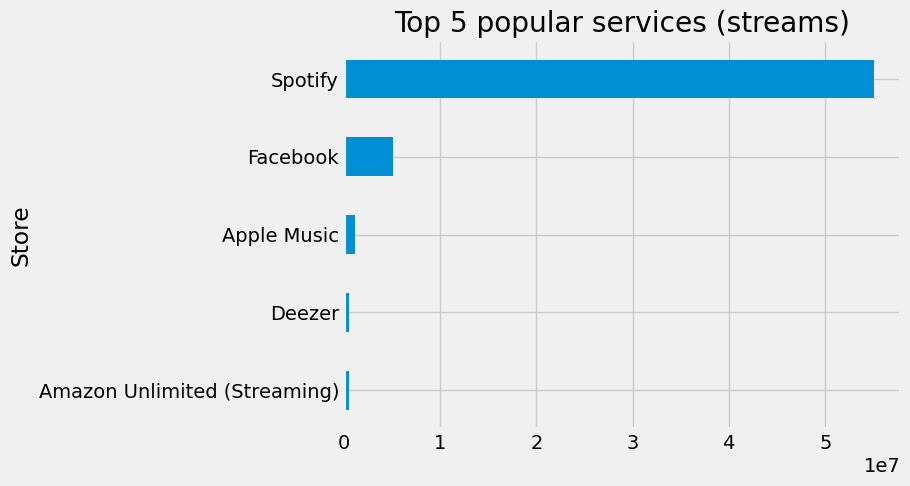

In [26]:
# Plotting streaming service earnings
store_quantity = subset_df.groupby('Store')['Quantity'].sum()

store_quantity\
.nlargest(5)\
.sort_values()\
.plot(
    kind = 'barh', 
    title = 'Top 5 popular services (streams)')

# Service payouts per stream

<AxesSubplot:title={'center':'Earnings per stream (USD)'}, ylabel='Store'>

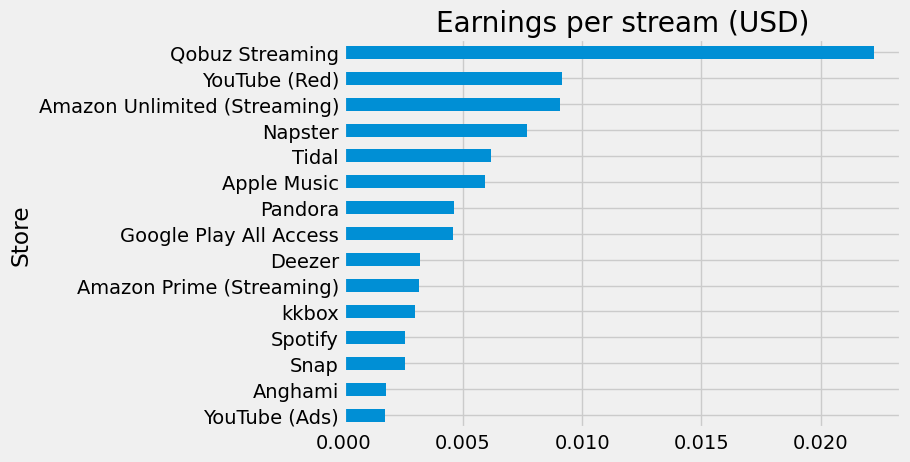

In [27]:
# Plotting streaming service earnings/stream
store_eps = (store_earnings_sub/store_quantity)
store_eps\
.nlargest(15)\
.sort_values()\
.plot(
    kind = 'barh', 
    title = 'Earnings per stream (USD)')

Even though Spotify is one of the better performing platforms for my music, it's ranked very low when looking at Earnings/Stream. This is likely linked to the vast amount of discoverability Spotify provides, because of their big user base. Low earings/stream might be a tradeoff for bigger reach. Especially for small-mid sized artists like myself that don't have many other established platforms. 

Apple Music, the second best earner, pays about 2x as much per stream compared to Spotify. Apple Music is very rewarding for the lower amount of streams generated, but harder to get discovered.

The services with the highest pay/stream generally generate less traffic because of that. To stay competetive and entice artists to put their music on their platforms, they have to do something different than the "giants" (Spotify, Apple, etc)

Based on these insights, I think  it's somewhat redundant to spend a large amount of resources to try grow on other platforms. However, as this is a fast growing and rapidly changing landscape, it would be smart to keep these trends in mind for future reevaluations.

# When do people listen

Looking the the graphs below, we can identify that the weekdays are quite equal, but with tuesday taking the lead. 

Then if we look at the months, we can see a low point during summer, July through september being the lowest performing months. And October through March being the best performing months. 

In [28]:
from statsmodels.formula.api import ols

In [29]:
# Defining the features we are interrested in
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

spotify_features = create_features(spotify_df)

## Streams by Weekday
The day of the week with Monday=0, Sunday=6.

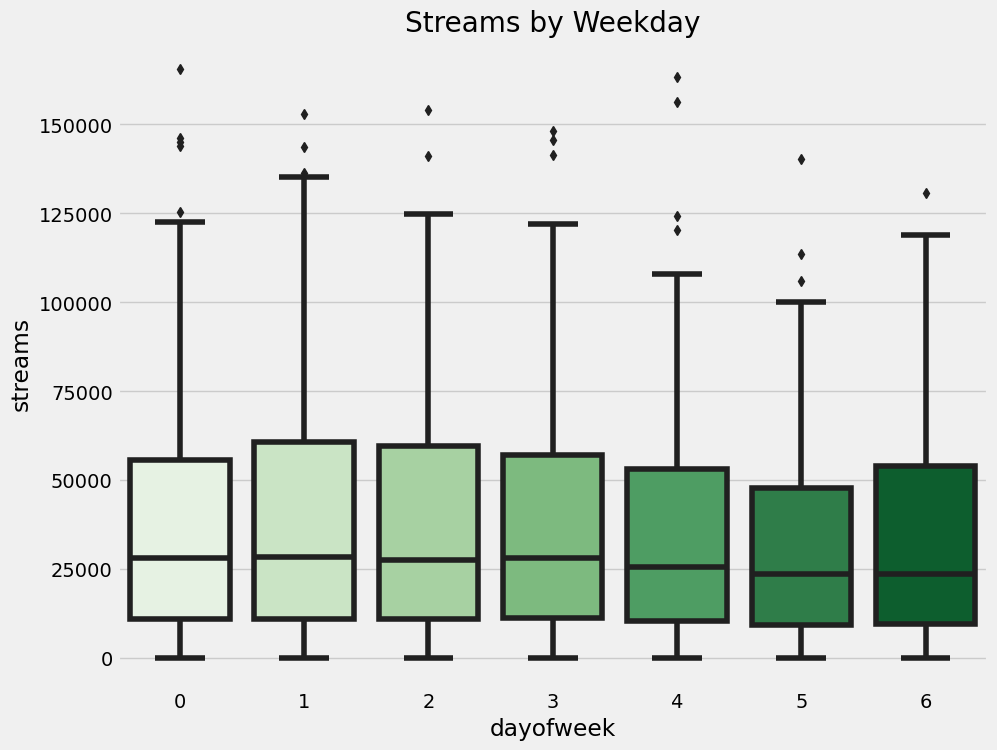

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=spotify_features, x='dayofweek', y='streams', palette='Greens')
ax.set_title('Streams by Weekday')
plt.show()

In [31]:
model = ols(formula="streams ~ C(dayofweek)", data=spotify_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.100
Date:                Wed, 19 Apr 2023   Prob (F-statistic):             0.0504
Time:                        22:26:31   Log-Likelihood:                -20708.
No. Observations:                1759   AIC:                         4.143e+04
Df Residuals:                    1752   BIC:                         4.147e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           3.73e+04   1983.776     18.801      0.000    3.34e+04    4.12e+04
C(dayofweek)[T.1]   874.6892   2805.483      0.312      0.755   -4627.758    6377.136
C(dayofweek)[T.2]    16.9681   2805.483      0.006      0.995   -5485.479    5519.415
C(dayofweek)[T.3]  -771.5817   2805.483     -0.275      0.783   -6274.029    4730.865
C(dayofweek)[T.4] -3050.1315   2805.483     -1.087      0.277   -8552.578    2452.315
C(dayofweek)[T.5] -6674.4475   2802.698     -2.381      0.017   -1.22e+04   -1177.462
C(dayofweek)[T.6] -4951.5308   2802.698     -1.767      0.077   -1.04e+04     545.455
==============================================================================
Omnibus:                      249.257   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              362.938
Skew:                           1.048   Prob(JB):                     1.55e-79
Kurtosis:                       3.748   Cond. No.                         7.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Streams by day of month

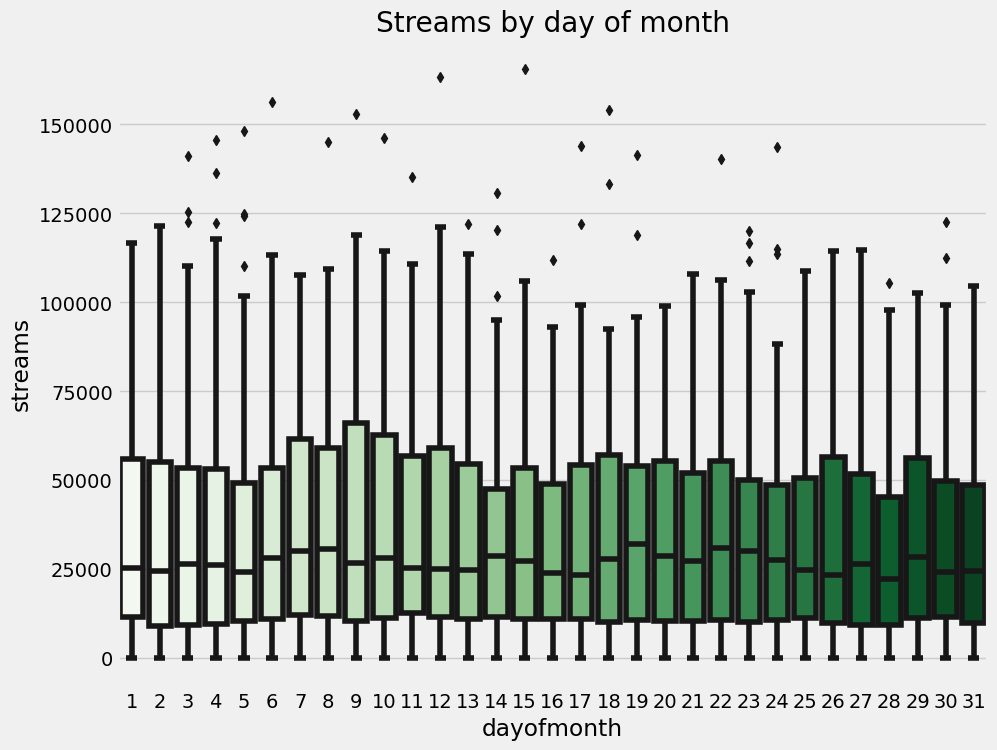

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=spotify_features, x='dayofmonth', y='streams', palette='Greens')
ax.set_title('Streams by day of month')
plt.show()

In [33]:
model = ols(formula="streams ~ C(dayofmonth)", data=spotify_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2524
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               1.00
Time:                        22:26:32   Log-Likelihood:                -20710.
No. Observations:                1759   AIC:                         4.148e+04
Df Residuals:                    1728   BIC:                         4.165e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3.434e+04   4197.528      8.180      0.000    2.61e+04    4.26e+04
C(dayofmonth)[T.2]  -1193.8941   5910.559     -0.202      0.840   -1.28e+04    1.04e+04
C(dayofmonth)[T.3]   2264.0541   5910.559      0.383      0.702   -9328.548    1.39e+04
C(dayofmonth)[T.4]   3629.6059   5910.559      0.614      0.539   -7962.996    1.52e+04
C(dayofmonth)[T.5]   1078.7266   5910.559      0.183      0.855   -1.05e+04    1.27e+04
C(dayofmonth)[T.6]   1595.2783   5910.559      0.270      0.787   -9997.324    1.32e+04
C(dayofmonth)[T.7]   3894.0714   5910.559      0.659      0.510   -7698.530    1.55e+04
C(dayofmonth)[T.8]   3629.2610   5910.559      0.614      0.539   -7963.341    1.52e+04
C(dayofmonth)[T.9]   5206.6576   5910.559      0.881      0.378   -6385.944    1.68e+04
C(dayofmonth)[T.10]  4476.7093   5910.559      0.757      0.449   -7115.893    1.61e+04
C(dayofmonth)[T.11]  2249.1748   5910.559      0.381      0.704   -9343.427    1.38e+04
C(dayofmonth)[T.12]  2030.5197   5910.559      0.344      0.731   -9562.082    1.36e+04
C(dayofmonth)[T.13]   623.6921   5910.559      0.106      0.916    -1.1e+04    1.22e+04
C(dayofmonth)[T.14]  1111.5714   5910.559      0.188      0.851   -1.05e+04    1.27e+04
C(dayofmonth)[T.15]  1012.6748   5910.559      0.171      0.864   -1.06e+04    1.26e+04
C(dayofmonth)[T.16] -3302.2045   5910.559     -0.559      0.576   -1.49e+04    8290.397
C(dayofmonth)[T.17]   183.5024   5910.559      0.031      0.975   -1.14e+04    1.18e+04
C(dayofmonth)[T.18]  1824.0024   5910.559      0.309      0.758   -9768.599    1.34e+04
C(dayofmonth)[T.19]  1389.1059   5910.559      0.235      0.814   -1.02e+04     1.3e+04
C(dayofmonth)[T.20]  -262.8596   5910.559     -0.044      0.965   -1.19e+04    1.13e+04
C(dayofmonth)[T.21] -1589.0493   5910.559     -0.269      0.788   -1.32e+04       1e+04
C(dayofmonth)[T.22]  1667.4852   5910.559      0.282      0.778   -9925.117    1.33e+04
C(dayofmonth)[T.23]  1908.3300   5910.559      0.323      0.747   -9684.272    1.35e+04
C(dayofmonth)[T.24]  -437.0665   5910.559     -0.074      0.941    -1.2e+04    1.12e+04
C(dayofmonth)[T.25] -2536.0321   5910.559     -0.429      0.668   -1.41e+04    9056.570
C(dayofmonth)[T.26]   537.9162   5910.559      0.091      0.927   -1.11e+04    1.21e+04
C(dayofmonth)[T.27] -1169.7018   5936.201     -0.197      0.844   -1.28e+04    1.05e+04
C(dayofmonth)[T.28] -2979.6316   5936.201     -0.502      0.616   -1.46e+04    8663.264
C(dayofmonth)[T.29]     9.7819   6047.168      0.002      0.999   -1.19e+04    1.19e+04
C(dayofmonth)[T.30]   574.4480   6077.223      0.095      0.925   -1.13e+04    1.25e+04
C(dayofmonth)[T.31] -1464.2536   6931.989     -0.211      0.833   -1.51e+04    1.21e+04
==============================================================================
Omnibus:    

## Streams by Month

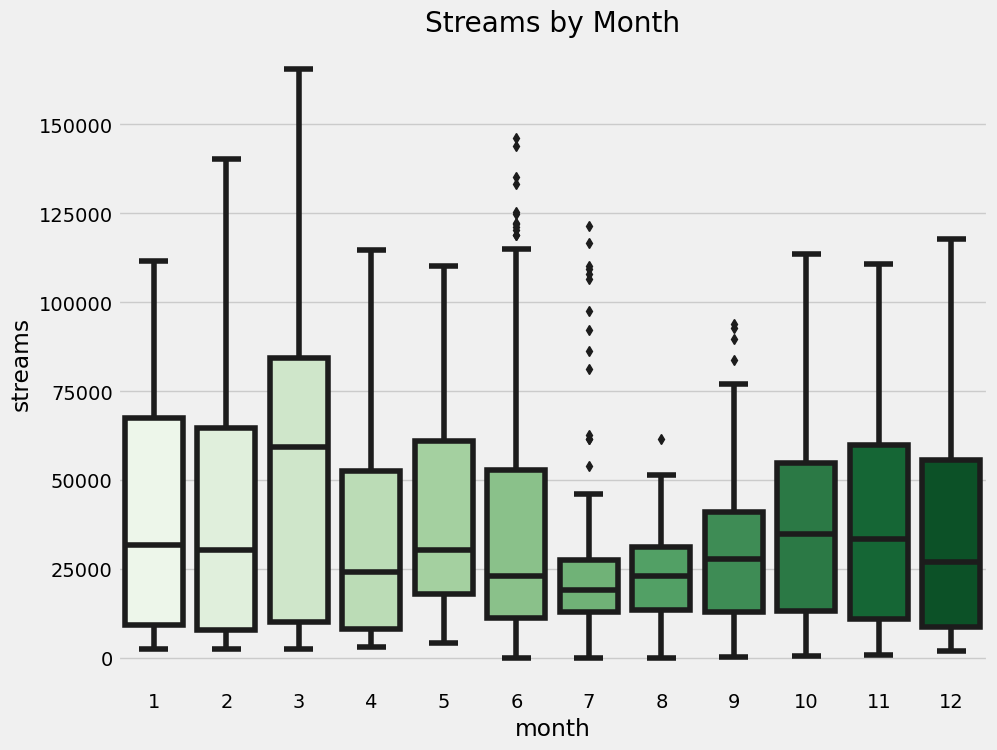

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=spotify_features, x='month', y='streams', palette='Greens')
ax.set_title('Streams by Month')
plt.show()

In [35]:
model = ols(formula="streams ~ C(month)", data=spotify_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     12.50
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           4.92e-23
Time:                        22:26:33   Log-Likelihood:                -20647.
No. Observations:                1759   AIC:                         4.132e+04
Df Residuals:                    1747   BIC:                         4.138e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.842e+04   2442.794     15.727      0.000    3.36e+04    4.32e+04
C(month)[T.2]    529.7647   3539.347      0.150      0.881   -6412.037    7471.567
C(month)[T.3]   1.669e+04   3483.302      4.792      0.000    9861.437    2.35e+04
C(month)[T.4]  -7630.4245   3697.963     -2.063      0.039   -1.49e+04    -377.525
C(month)[T.5]   1648.6242   3664.191      0.450      0.653   -5538.037    8835.286
C(month)[T.6]    665.0235   3489.237      0.191      0.849   -6178.497    7508.544
C(month)[T.7]  -1.441e+04   3454.632     -4.170      0.000   -2.12e+04   -7630.028
C(month)[T.8]  -1.691e+04   3454.632     -4.896      0.000   -2.37e+04   -1.01e+04
C(month)[T.9]  -1.007e+04   3483.302     -2.890      0.004   -1.69e+04   -3236.376
C(month)[T.10] -2153.6194   3454.632     -0.623      0.533   -8929.269    4622.030
C(month)[T.11] -1216.4028   3483.302     -0.349      0.727   -8048.283    5615.477
C(month)[T.12] -4662.7806   3454.632     -1.350      0.177   -1.14e+04    2112.869
==============================================================================
Omnibus:                      153.616   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.486
Skew:                           0.788   Prob(JB):                     9.66e-43
Kurtosis:                       3.398   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Streams by Quarter

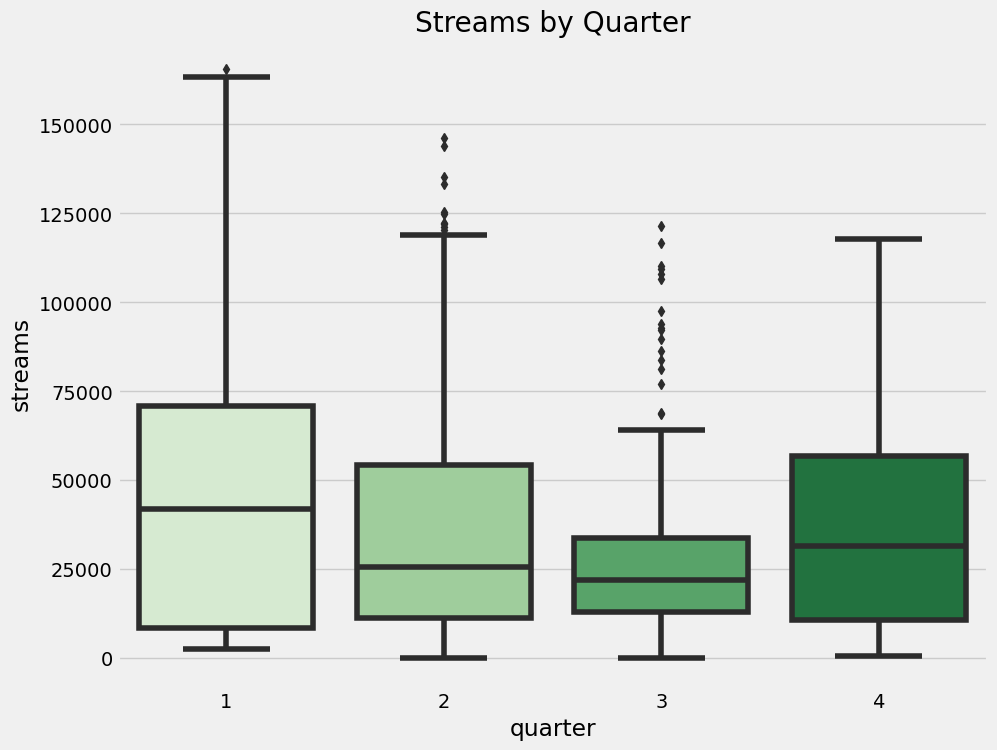

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=spotify_features, x='quarter', y='streams', palette='Greens')
ax.set_title('Streams by Quarter')
plt.show()

In [37]:
model = ols(formula="streams ~ C(quarter)", data=spotify_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     31.55
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           7.31e-20
Time:                        22:26:34   Log-Likelihood:                -20668.
No. Observations:                1759   AIC:                         4.134e+04
Df Residuals:                    1755   BIC:                         4.137e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         4.42e+04   1453.581     30.407      0.000    4.13e+04    4.71e+04
C(quarter)[T.2] -7339.4165   2123.850     -3.456      0.001   -1.15e+04   -3173.874
C(quarter)[T.3] -1.962e+04   2039.973     -9.617      0.000   -2.36e+04   -1.56e+04
C(quarter)[T.4] -8475.3095   2039.973     -4.155      0.000   -1.25e+04   -4474.277
==============================================================================
Omnibus:                      196.285   Durbin-Watson:                   0.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.967
Skew:                           0.896   Prob(JB):                     2.90e-58
Kurtosis:                       3.638   Cond. No.                         4.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Streams by day of year

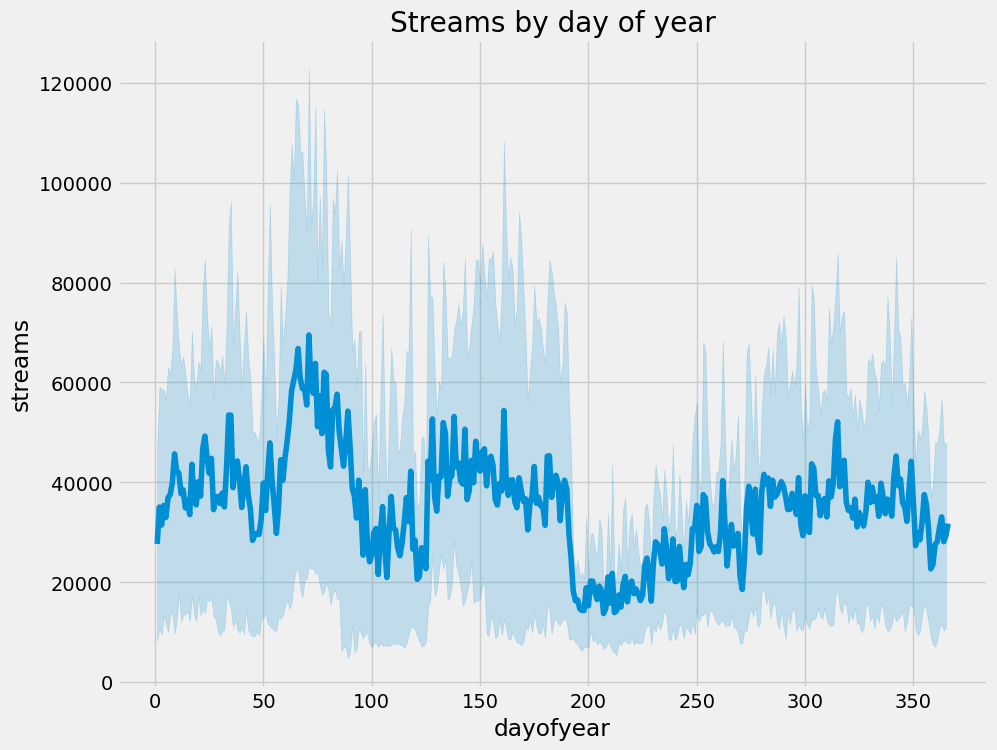

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=spotify_features, x='dayofyear', y='streams')
ax.set_title('Streams by day of year')
plt.show()

In [39]:
#since there are too many values let's extract the R^2 result
model = ols(formula="streams ~ C(dayofyear)", data=spotify_features).fit()
print(f'R^2 = {model.rsquared}')

R^2 = 0.11177968748176303


## Streams by year

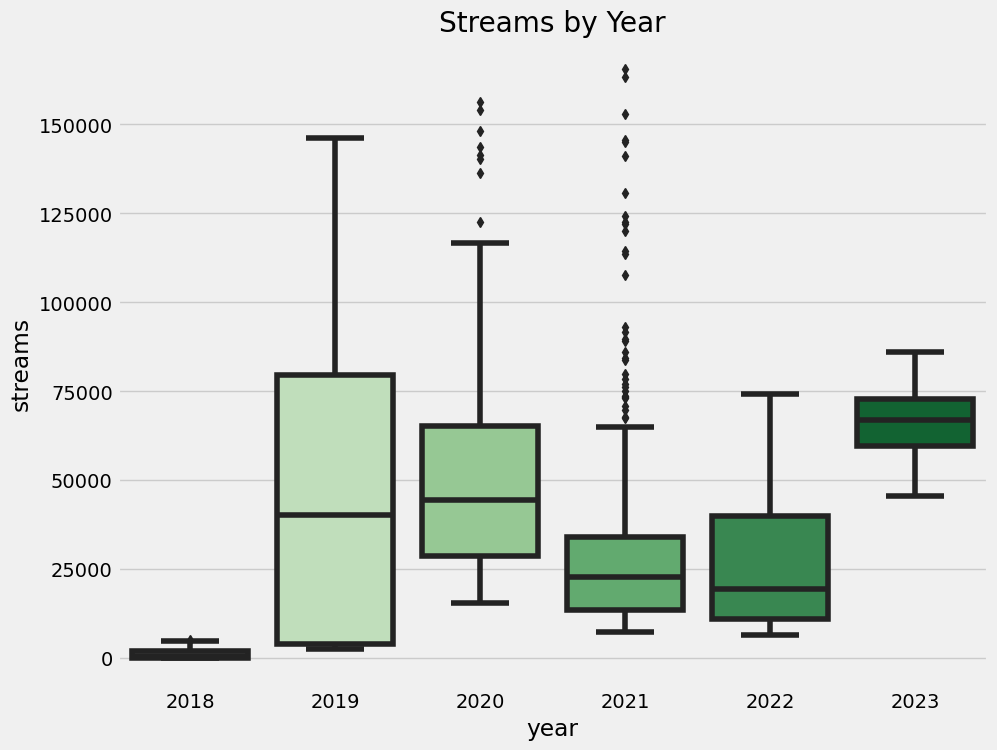

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=spotify_features, x='year', y='streams', palette='Greens')
ax.set_title('Streams by Year')
plt.show()

In [41]:
model = ols(formula="streams ~ C(year)", data=spotify_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     136.0
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          4.52e-122
Time:                        22:26:45   Log-Likelihood:                -20426.
No. Observations:                1759   AIC:                         4.086e+04
Df Residuals:                    1753   BIC:                         4.090e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1099.6995   1833.898      0.600      0.549   -2497.158    4696.557
C(year)[T.2019]  4.411e+04   2307.771     19.115      0.000    3.96e+04    4.86e+04
C(year)[T.2020]   4.96e+04   2306.609     21.505      0.000    4.51e+04    5.41e+04
C(year)[T.2021]  2.956e+04   2307.771     12.808      0.000     2.5e+04    3.41e+04
C(year)[T.2022]   2.58e+04   2307.771     11.179      0.000    2.13e+04    3.03e+04
C(year)[T.2023]  6.522e+04   3433.791     18.994      0.000    5.85e+04     7.2e+04
==============================================================================
Omnibus:                      368.687   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              802.797
Skew:                           1.184   Prob(JB):                    4.73e-175
Kurtosis:                       5.311   Cond. No.                         8.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## R values of all features
With the measured R values we can see how much our features influence the stream amount

In [42]:
model = ols(formula="streams ~ C(dayofweek) + C(dayofmonth) + C(month) + C(quarter) + C(dayofyear)+ C(year)", data=spotify_features).fit()
print(f'R squared: {model.rsquared}, \n R squared-adjusted:{model.rsquared_adj}')

R squared: 0.4298897669356222, 
 R squared-adjusted:0.25316409111238736


# Predicting Spotify Stats

## Spliting our data for testing and training

In [43]:
start_date = '03-01-2019'
last_known_date = '08-01-2021'

#Trim unwanted properties
Spotify_streams_df = spotify_df.drop('followers', axis=1)
Spotify_streams_df = Spotify_streams_df.drop('listeners', axis=1)

#Drop dates before first getting streams
Spotify_streams_df = Spotify_streams_df.loc[Spotify_streams_df.index > start_date]

train = Spotify_streams_df.loc[Spotify_streams_df.index < last_known_date]
test = Spotify_streams_df.loc[Spotify_streams_df.index >= last_known_date]

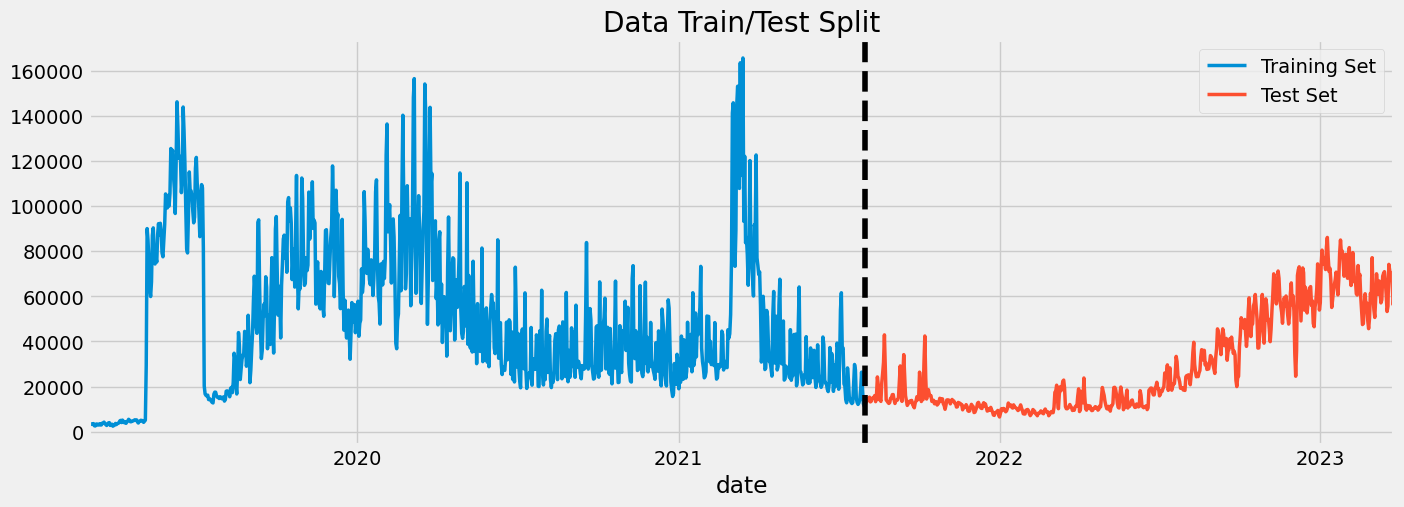

In [44]:
# Visualize split
ig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', lw='2.5')
test.plot(ax=ax, label='Test Set', lw='2.5')
ax.axvline(last_known_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [45]:
FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','dayofmonth']
TARGET = 'streams'

In [46]:
train = create_features(train)
X_train = train[FEATURES]
y_train = train[TARGET]

test = create_features(test)
X_test = test[FEATURES]

## Creating a model
For this task we will use XGBoost, which is an effective Gradient Boosting library. We will use linear regression to make our prediction.

In [47]:
params = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5]
}
              
                    
test_reg = xgb.XGBRegressor(booster='gbtree',
                            objective='reg:squarederror',
                            early_stopping_rounds=50)

grid_search = GridSearchCV(
    estimator=test_reg,
    param_grid=params,
    refit='f1',
    n_jobs = 3,
    cv = 3,
    verbose=False
)
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}

In [48]:
reg = xgb.XGBRegressor(booster='gbtree',    
                       objective='reg:squarederror',
                       **best_params)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100)

[0]	validation_0-rmse:58882.82534
[100]	validation_0-rmse:27919.47508
[199]	validation_0-rmse:18717.44197


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

## Visualize feature importance
Based on training data

## Prediction evaluation and evaluation

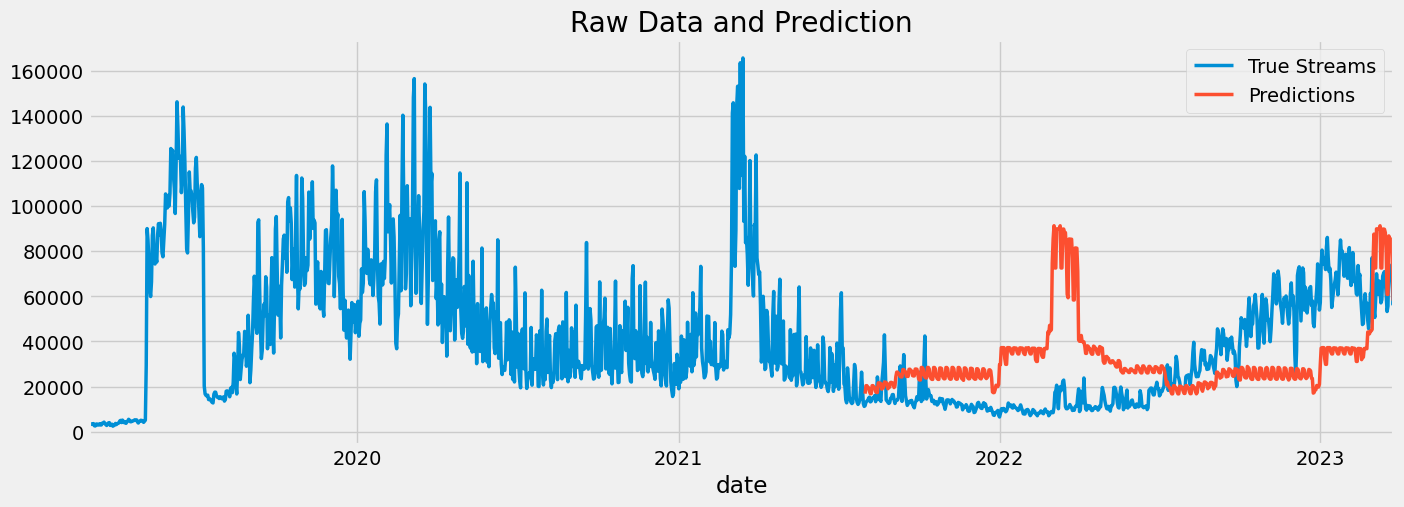

In [49]:
test['prediction'] = reg.predict(X_test)
df = Spotify_streams_df.merge(test[['prediction']], how='right', left_index=True, right_index=True)
ax = Spotify_streams_df[['streams']].plot(figsize=(15, 5), lw='2.5')
df['prediction'].plot(ax=ax, lw='2.5')
plt.legend(['True Streams', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [50]:
score = np.sqrt(mean_squared_error(test['streams'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 25800.39


## Predict next 360 days

In [51]:
start_date = '07-01-2018'
last_known_date = Spotify_streams_df.index[0]

train = Spotify_streams_df.tail(-1)
train = create_features(train)
X_train = train[FEATURES]
y_train = train[TARGET]

test = Spotify_streams_df.head(1)
# Adding more days to predict
test = test.reindex(df.index + pd.DateOffset(days=360))
test = test.loc[test.index >= last_known_date]

test.streams = test.streams.fillna(0)
test = create_features(test)
X_test = test[FEATURES]
y_test = test[TARGET]

In [52]:
# Train model with all known streaming dates
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=250)

[0]	validation_0-rmse:50970.35175
[199]	validation_0-rmse:17793.55699


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

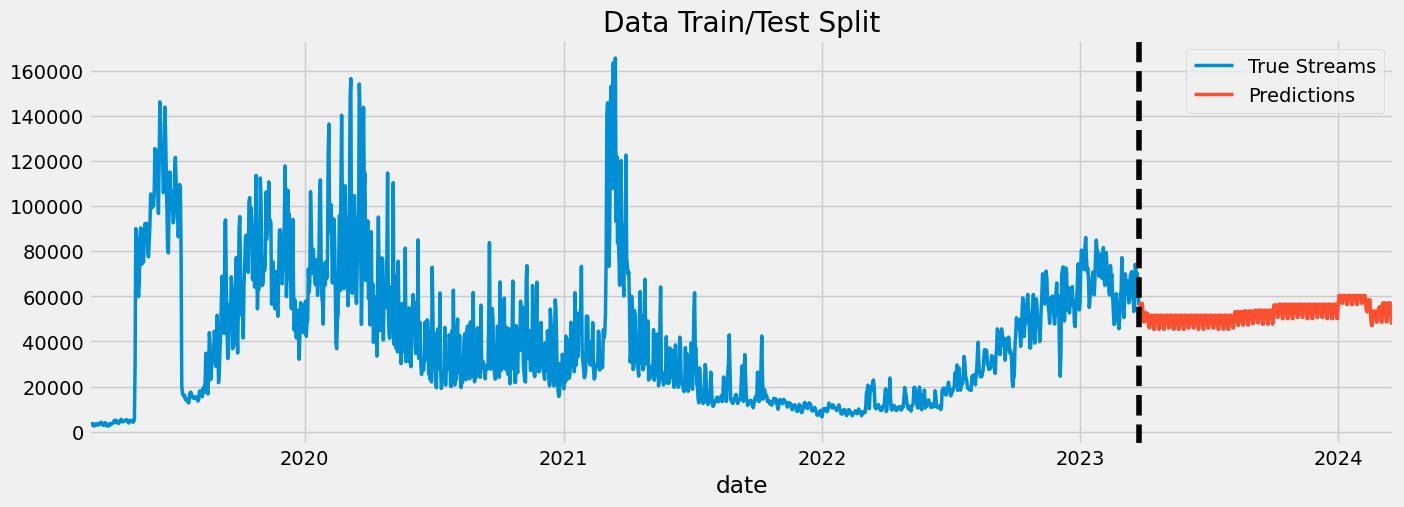

In [53]:
# Plot
test['prediction'] = reg.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', lw='2.5')
test['prediction'].plot(ax=ax, label='Test Set', lw='2.5')
ax.axvline(last_known_date, color='black', ls='--')
ax.legend(['True Streams', 'Predictions'])
plt.show()

## Visualize feature importance
Based on complete data

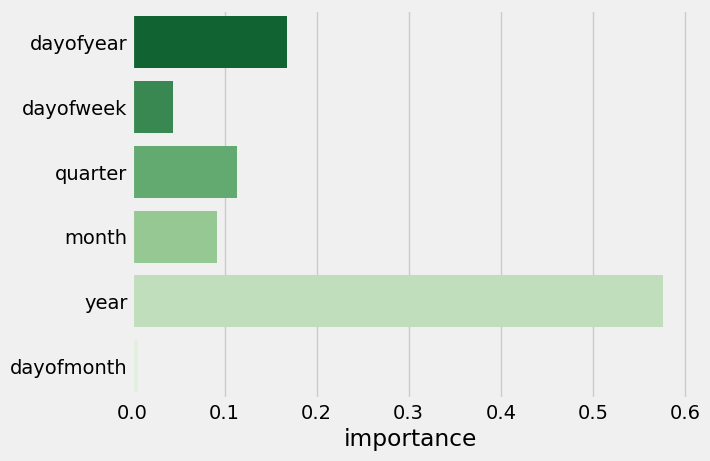

In [54]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
sns.barplot(data=fi, x='importance', y=reg.feature_names_in_, palette='Greens_r')
plt.show()

## prediction complete

The predicted plot looks reasonable at a first glance. Considering the fluctuating behaviour of the data, it's going to be fun to see how correct the prediction is.